In [1]:
# Imports
import gzip # as some instance files may have been compressed

# Re-import dependencies (in case earlier import was skipped)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from permutationsga.ga import (
    ConfigurableGA,

    RandomPermutationInitialization,
    crossover_ox,
    crossover_cx,
    crossover_pmx,
    TournamentSelection,
    FunctionBasedRecombinator,
    SequentialSelector,
    generate_uniform_indices,
    generate_sequential_indices,
    generate_sequential_wrapping_indices,

    RandomUniformInitialization,
    DifferentialEvolutionRecombinator,
    
    
)
from permutationsga.problem import IdenticalDecoder, InvPermDecoder, RandomKeysDecoder

from permutationsga.qap import QAP, read_qaplib
from mutation_initialization.frequency_based_initialization import FrequencyBasedInitialization

In [2]:
# The bur* instances are those that we will be using - note that we are only using 26 keys in this case.
problem = QAP(*read_qaplib("./instances/qap/bur26a.dat"))

In [3]:
distance_matrix = problem.A
frequency_matrix = problem.B

if distance_matrix[0][0] == 53:
    type = 0
if distance_matrix[0][0] == 37:
    type = 1
else:
    Exception("The distance matrix is not as expected")

row_sum = np.sum(frequency_matrix, axis = 1)
col_sum = np.sum(frequency_matrix, axis = 0)
frequencies = np.add(row_sum, col_sum)
high_frequency = np.argsort(frequencies)[-8:]
print(f"type: {type}, high frequency characters: {high_frequency}")

type: 0, high frequency characters: [ 7 18  0 19 17  8 13  4]


In [4]:
row_sum = np.sum(distance_matrix, axis = 1)
col_sum = np.sum(distance_matrix, axis = 0)
distances = np.add(row_sum, col_sum)
better_region = np.argsort(distances)[:8]
print(better_region)

[18 17 16 12 10 11  9 13]


In [6]:
problem = IdenticalDecoder(problem) 

In [7]:
# GA - Permutation
seed = 42
population_size = 2**11
rng = np.random.default_rng(seed=seed + 1)
l = problem.get_length()


crossover_fn = crossover_pmx; indices_gen = lambda: generate_sequential_indices(rng, l)
# crossover_fn = crossover_pmx; indices_gen = lambda: generate_uniform_indices(rng, l, 0.5)
# crossover_fn = crossover_ox; indices_gen = lambda: generate_sequential_indices(rng, l)
# crossover_fn = crossover_cx; indices_gen = lambda: rng.integers(0, l - 1, size=1)
# crossover_fn = crossover_cx; indices_gen = lambda: generate_uniform_indices(rng, l, 0.05)

p = 1e-3
initialization = FrequencyBasedInitialization(p, type, high_frequency, better_region)
#initialization = RandomPermutationInitialization(l)
parent_selection = SequentialSelector()
recombinator = FunctionBasedRecombinator(
    indices_gen,
    crossover_fn,
    parent_selection,
    population_size * 2, # Note: double as we are including the previous population
    include_what="population"
)
selection = TournamentSelection()
ga = ConfigurableGA(
    seed, population_size, problem, initialization, recombinator, selection
)


In [8]:
ga.generation()
print(ga.population[0].e)

[24  1 22 20  6 14 23  5 16 17  8  7 18  4 15 25 13  0 19  9 12  3  2 11
 21 10]


In [9]:
# Current best & worst
min(s.f for s in ga.population), max(s.f for s in ga.population)

(5489773.0, 5826251.0)

Recombine & Select (repeat a few times to see how things evolve!):

In [10]:
differences = []
p = 1e-2
seed = 42
population_size = 2**11
rng = np.random.default_rng(seed=seed + 1)
l = problem.get_length()


crossover_fn = crossover_pmx; indices_gen = lambda: generate_sequential_indices(rng, l)
# crossover_fn = crossover_pmx; indices_gen = lambda: generate_uniform_indices(rng, l, 0.5)
# crossover_fn = crossover_ox; indices_gen = lambda: generate_sequential_indices(rng, l)
# crossover_fn = crossover_cx; indices_gen = lambda: rng.integers(0, l - 1, size=1)
#crossover_fn = crossover_cx; indices_gen = lambda: generate_uniform_indices(rng, l, 0.05)

initialization = FrequencyBasedInitialization(p, type, high_frequency, better_region)
#initialization = RandomPermutationInitialization(l)
parent_selection = SequentialSelector()
recombinator = FunctionBasedRecombinator(
    indices_gen,
    crossover_fn,
    parent_selection,
    population_size * 2, # Note: double as we are including the previous population
    include_what="population"
)
selection = TournamentSelection()
ga = ConfigurableGA(
    seed, population_size, problem, initialization, recombinator, selection
)
while True:
    ga.generation()
    differences.append(max(s.f for s in ga.population) - min(s.f for s in ga.population))
    if differences[-1] == 0:
        break
    


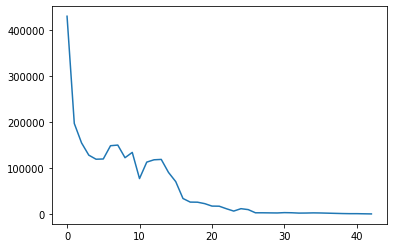

In [11]:
# plot the differences in plt.line
plt.plot(differences)

In [12]:
print(len(differences))

43


In [13]:
# Current best & worst
min(s.f for s in ga.population), max(s.f for s in ga.population)

(5435853.0, 5435853.0)

In [14]:
# print the genotype of the best
print(ga.population[np.argmin(s.f for s in ga.population)].e)

[14  2 25  6 10 11  1 21 20 17  4 19  0  7  5 12 13 18  8 16  9 24 15  3
 22 23]


In [15]:
# Tuning the p value
p_values = [0.1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
results = [[], [], [], [], [], []]
best_results = [[], [], [], [], [], []]

i=0
for p in p_values:
    differences = []
    best = []
    seed = 42
    population_size = 2**11
    rng = np.random.default_rng(seed=seed + 1)
    l = problem.get_length()


    crossover_fn = crossover_pmx; indices_gen = lambda: generate_sequential_indices(rng, l)
    # crossover_fn = crossover_pmx; indices_gen = lambda: generate_uniform_indices(rng, l, 0.5)
    # crossover_fn = crossover_ox; indices_gen = lambda: generate_sequential_indices(rng, l)
    # crossover_fn = crossover_cx; indices_gen = lambda: rng.integers(0, l - 1, size=1)
    #crossover_fn = crossover_cx; indices_gen = lambda: generate_uniform_indices(rng, l, 0.05)

    initialization = FrequencyBasedInitialization(p, type, high_frequency, better_region)
    parent_selection = SequentialSelector()
    recombinator = FunctionBasedRecombinator(
        indices_gen,
        crossover_fn,
        parent_selection,
        population_size * 2, # Note: double as we are including the previous population
        include_what="population"
    )
    selection = TournamentSelection()
    ga = ConfigurableGA(
        seed, population_size, problem, initialization, recombinator, selection
    )
    while True:
        ga.generation()
        #print(f"probability: {p}, {min(s.f for s in ga.population)}")
        differences.append(max(s.f for s in ga.population) - min(s.f for s in ga.population))
        if differences[-1] == 0:
            break
        results[i].append(min(s.f for s in ga.population))
    best_results[i] = min(s.f for s in ga.population)
    i += 1
print(best_results)
print(f"best results: {min(best_results)} with p = {p_values[np.argmin(best_results)]}")

[5438261.0, 5435853.0, 5437297.0, 5443807.0, 5443807.0, 5443807.0]
best results: 5435853.0 with p = 0.01


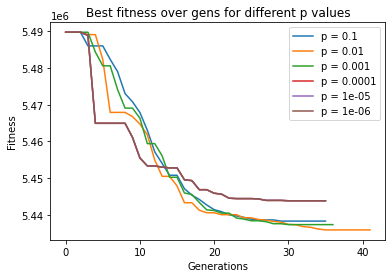

In [16]:
# plot results for different p values in one plot
plt.plot(results[0], label=f"p = {p_values[0]}")
plt.plot(results[1], label=f"p = {p_values[1]}")
plt.plot(results[2], label=f"p = {p_values[2]}")
plt.plot(results[3], label=f"p = {p_values[3]}")
plt.plot(results[4], label=f"p = {p_values[4]}")
plt.plot(results[5], label=f"p = {p_values[5]}")
plt.legend()
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.title("Best fitness over gens for different p values")
plt.show()

 p = 0.01 converges to a better value 
 

In [17]:
from configs        import EA_Config, Exp_Config, rng, l
from run_experiment import run_experiments, round_to_multiple
from math       import ceil

p = 1e-2
EA_Config(crossover_fn=crossover_pmx, indices_gen=lambda: generate_sequential_indices(rng, l), initialization=RandomPermutationInitialization(l))
EA_Config(crossover_fn=crossover_pmx, indices_gen=lambda: generate_sequential_indices(rng, l), initialization=FrequencyBasedInitialization(p, type, high_frequency, better_region))


setups = {
    "Random Permutation Initialisation"    : EA_Config(crossover_fn=crossover_pmx, indices_gen=lambda: generate_sequential_indices(rng, l), initialization=RandomPermutationInitialization(l))
,
    "Frequency Based Initialisation"       : EA_Config(crossover_fn=crossover_pmx, indices_gen=lambda: generate_sequential_indices(rng, l), initialization=FrequencyBasedInitialization(p, type, high_frequency, better_region))
}

exp_cfg = Exp_Config("crossover_indices")

all_best_overtime, all_worst_overtime, all_iterations, all_total_times, all_iter_times = run_experiments(setups, exp_cfg)

colors = ["orange", "blue"]

ncols = 2
nrows = 1

alltime_worst   = max([max(x) for x in all_worst_overtime])
alltime_best    = min([min(x) for x in all_best_overtime])



Random Permutation Initialisation
	Best:  5450527.0                                                                                   
	Worst: 5450527.0
	Diff:  0.0

Frequency Based Initialisation
	Best:  5438635.0                                                                                   
	Worst: 5438635.0
	Diff:  0.0



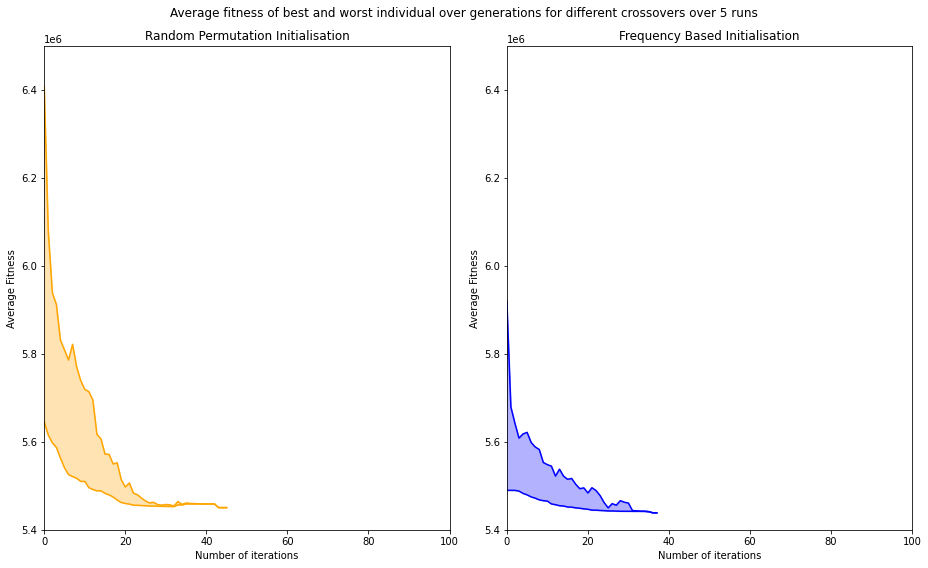

In [18]:
ylim_min = round_to_multiple(alltime_best,  100000, int)
ylim_max = round_to_multiple(alltime_worst, 100000, ceil)


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13, 8))


for i in range(ncols * nrows - len(setups)):
    i += len(setups)

    fig.delaxes(axes[i // ncols, i % ncols])

for i, (setup_name, best_overtime, worst_overtime, color) in enumerate(zip(setups.keys(), all_best_overtime, all_worst_overtime, colors)):
    ax = axes[i]
    
    ax.plot(best_overtime,  color=color)
    ax.plot(worst_overtime, color=color)
    ax.fill_between(np.arange(len(best_overtime)), best_overtime, worst_overtime, color=color, alpha=0.3)

    ax.set_ylabel("Average Fitness")
    ax.set_xlabel("Number of iterations")
    ax.set_xlim(0, exp_cfg.max_gen)
    ax.set_ylim(ylim_min, ylim_max)
    ax.set_title(setup_name)

plt.suptitle(f"Average fitness of best and worst individual over generations for different crossovers over {exp_cfg.n_experiments} runs")
fig.tight_layout()
plt.show()

In [19]:
differences = []
p = 1e-2
seed = 42
population_size = 2**11
rng = np.random.default_rng(seed=seed + 1)
l = problem.get_length()


crossover_fn = crossover_pmx; indices_gen = lambda: generate_sequential_indices(rng, l)
# crossover_fn = crossover_pmx; indices_gen = lambda: generate_uniform_indices(rng, l, 0.5)
# crossover_fn = crossover_ox; indices_gen = lambda: generate_sequential_indices(rng, l)
# crossover_fn = crossover_cx; indices_gen = lambda: rng.integers(0, l - 1, size=1)
#crossover_fn = crossover_cx; indices_gen = lambda: generate_uniform_indices(rng, l, 0.05)

results = [[],[]]

for i in range(2):
    if i ==0:
        initialization = RandomPermutationInitialization(l)
    else:
        initialization = FrequencyBasedInitialization(p, type, high_frequency, better_region)
    parent_selection = SequentialSelector()
    recombinator = FunctionBasedRecombinator(
        indices_gen,
        crossover_fn,
        parent_selection,
        population_size * 2, # Note: double as we are including the previous population
        include_what="population"
    )
    selection = TournamentSelection()
    ga = ConfigurableGA(
        seed, population_size, problem, initialization, recombinator, selection
    )
    while True:
        ga.generation()
        results[i] = [s.f for s in ga.population]
        differences.append(max(s.f for s in ga.population) - min(s.f for s in ga.population))
        if differences[-1] == 0:
            break
        break

Text(0.5, 0.98, 'Histogram of fitness values for different initializations')

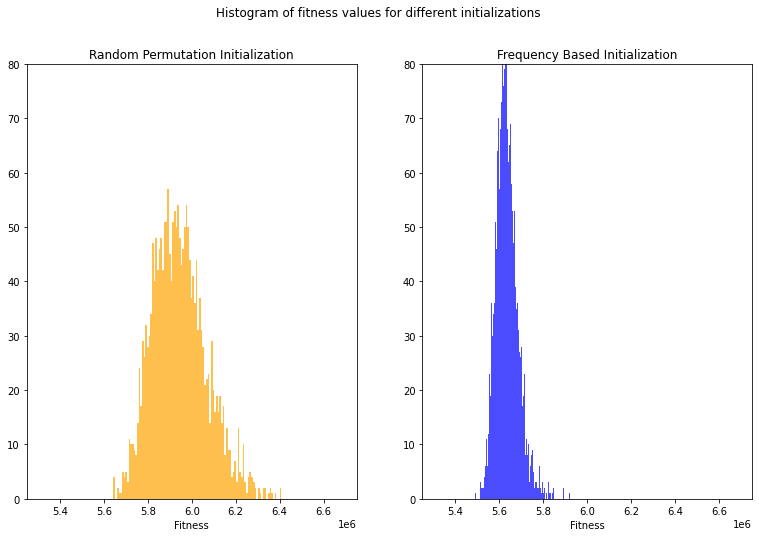

In [20]:
# make histogram of results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 8))
histogram = axes[0].hist(results[0], bins=100, color="orange", alpha=0.7)
axes[1].set_title("Frequency Based Initialization")
histogram_2 = axes[1].hist(results[1], bins=100, color="blue", alpha=0.7)
axes[0].set_title("Random Permutation Initialization")
axes[1].set_xlabel("Fitness")
axes[0].set_xlabel("Fitness")
axes[1].set_ylim(0,80)
axes[0].set_ylim(0,80)
axes[0].set_xlim(5.25e6,6.75e6)
axes[1].set_xlim(5.25e6,6.75e6)
fig.suptitle("Histogram of fitness values for different initializations")

Text(0.5, 0.98, 'Boxplot of fitness values for different initializations')

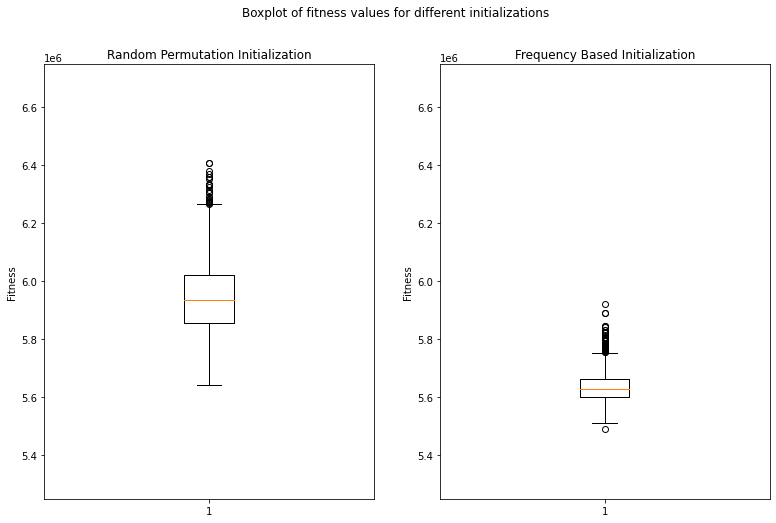

In [21]:
#Create boxplot of results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 8))
axes[0].boxplot(results[0])
axes[1].set_title("Frequency Based Initialization")
axes[1].boxplot(results[1])
axes[0].set_title("Random Permutation Initialization")
axes[1].set_ylim(5.25e6, 6.75e6)
axes[0].set_ylim(5.25e6, 6.75e6)
axes[0].set_ylabel("Fitness")
axes[1].set_ylabel("Fitness")
fig.suptitle("Boxplot of fitness values for different initializations")